In [42]:
from load_oxford_flowers102 import load_oxford_flowers102
import show_methods
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import gzip
import pickle
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Rescaling
from sklearn.metrics import multilabel_confusion_matrix


colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
train_data, validation_data, test_data, class_names = load_oxford_flowers102(imsize=96, fine=False)
y_train = train_data["labels"]
y_test = test_data["labels"]
x_train = train_data["images"]
x_test = test_data["images"]
x_valid = validation_data["images"]
y_valid = validation_data["labels"]
# SEED = 1
input_shape = (96, 96, 3)
n_classes = len(class_names)

In [11]:
def class_proportions(labels, n_classes):
    # Create a dictionary with labels as keys and proportions as values
    proportions = np.zeros(n_classes)
    
    ## Count the number of examples of each class
    for label in labels:
        proportions[label] += 1

    return {label: proportion for label, proportion in enumerate(proportions)}


def balanced_accuracy(test_labels, predictions, outputs, name="balanced accuracy"):    
    # https://github.com/rois-codh/kmnist/pull/14/files/2b063db29fc7aa784a60ba69e13f72db892bf435
    totals = []
    for cls in range(outputs):
        total = 0
        for i in test_labels:
            if i == cls:
                total = total + 1
        totals.append(total)

    hits = []
    for cls in range(outputs):
        total_hits = 0
        for i in range(0, test_labels.shape[0]):
            if test_labels[i] == cls == np.argmax(predictions[i]):
                total_hits = total_hits + 1
        hits.append(total_hits)

    accuracy_list = []
    for i in range(0, len(hits)):
        accuracy = hits[i] / totals[i]
        accuracy_list.append(accuracy)

    return np.mean(accuracy_list)

In [44]:

def eval_net(net, epochs=50, load_from_file=False, net_name="net", summary=False, verbose=1, show_train_graph=False, data_aug=False,show_predictions=False, callbacks=[]):
    save_name = os.path.join('saved', f'{net_name}')
    net_save_name = save_name + '_cnn_net.h5'
    checkpoint_save_name = save_name + '_cnn_net.chk.weights.h5'
    history_save_name = save_name + '_cnn_net.hist'


    if load_from_file and os.path.isfile(net_save_name):
      net = tf.keras.models.load_model(net_save_name)
      with gzip.open(history_save_name) as f:
         history = pickle.load(f)
    else:           
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_save_name,
            save_weights_only=True,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)
        callbacks = callbacks.append(model_checkpoint_callback)
        if data_aug:
            datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                zca_epsilon=1e-06,
                width_shift_range=0.1,
                height_shift_range=0.1,
                fill_mode='nearest',
                horizontal_flip=True
            )
            datagen.fit(x_train)

            train_data_aug = datagen.flow(x_train, y_train)

            train_info = net.fit(train_data_aug,
                                 validation_data=(x_valid, y_valid),
                                 epochs=epochs, shuffle=True,
                                 callbacks=callbacks,
                                 verbose=verbose)
        else:
            train_info = net.fit(x_train, y_train, 
                                 validation_data=(x_valid, y_valid),
                                 epochs=epochs, shuffle=True,
                                 callbacks=callbacks,
                                 verbose=verbose)
        net.save(net_save_name)
        history = train_info.history
        with gzip.open(history_save_name, 'w') as f:
            pickle.dump(history, f)

    if summary:
        net.summary()

    # Compute output for 16 test images
    y_test_pred = net.predict(x_test)
    y_train_pred = net.predict(x_train)

    loss_train, accuracy_train,  = net.evaluate(x_train, y_train, verbose=0)
    loss_test, accuracy_test = net.evaluate(x_test, y_test, verbose=0)

    bacc_test = balanced_accuracy(y_test, y_test_pred, n_classes)
    bacc_train = balanced_accuracy(y_train, y_train_pred, n_classes)

    print("Train accuracy (tf): %.2f" % accuracy_train)
    print("Test accuracy  (tf): %.2f" % accuracy_test)
    print("Train balanced accuracy (tf): %.2f" % bacc_train)
    print("Test balanced accuracy  (tf): %.2f" % bacc_test)
    # cm=multilabel_confusion_matrix(y_test,y_test_pred)
    # cmm=multilabel_confusion_matrix(x_train,y_train_pred)
    # print(cm)
    # print(cmm)


    if show_train_graph:
        #Plot training and validation accuracy over the course of training
        fh = plt.figure()
        ph = fh.add_subplot(111)
        ph.plot(history['accuracy'], label='accuracy')
        ph.plot(history['val_accuracy'], label = 'val_accuracy')
        ph.set_xlabel('Epoch')
        ph.set_ylabel('Accuracy')
        ph.set_ylim([0, 1])
        ph.legend(loc='lower right')
        plt.show()
        
    if show_predictions:
        show_methods.show_data_images(images=x_test[:16],
                            labels=y_test[:16],predictions= np.argmax(y_test_pred, axis=1),
                            class_names=class_names)

# Models

In [13]:
def simple_cnn():
    return tf.keras.models.Sequential([
        Rescaling(1./255, input_shape=input_shape),
        Conv2D(16, 3, activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(32, 3, strides=(2, 2), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Flatten(),
        Dense(units=32, activation='relu'),
        Dense(units=n_classes, activation='softmax')
    ])

In [14]:
def medium_cnn():   
    return tf.keras.models.Sequential([
        Rescaling(1./255, input_shape=input_shape),
        Conv2D(64, 3, activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(128, 3, activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(256, 3, strides=(2, 2), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Flatten(),
        Dense(units=512, activation='relu'),
        Dense(units=128, activation='relu'),
        Dense(units=n_classes, activation='softmax')
    ])

In [38]:
def large_cnn():
    return tf.keras.models.Sequential([
        Rescaling(1./255, input_shape=input_shape),
        Conv2D(32, 3, activation='relu', padding='same'),
        Conv2D(32, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(64, 3, activation='relu', padding='same'),
        Conv2D(64, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(128, 3, activation='relu', padding='same'),
        Conv2D(128, 3, activation='relu', padding='same'),
        Conv2D(128, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(256, 3, activation='relu', padding='same'),
        Conv2D(256, 3, activation='relu', padding='same'),
        Conv2D(256, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        # Dropout(0.2),
        Flatten(),
        Dense(units=128, activation='relu'),
        Dense(units=128, activation='relu'),
        Dense(units=n_classes, activation='softmax')
    ])

# Training

In [46]:
net = large_cnn()
net.summary()
net.compile(optimizer=tf.keras.optimizers.Adam(),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_9 (Rescaling)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 96, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 10)             │         1,29

 Total params: 3,109,418 (11.86 MB)

 Trainable params: 3,108,458 (11.86 MB)

 Non-trainable params: 960 (3.75 KB)

## Call Backs

In [23]:
# adapted from https://www.tensorflow.org/tutorials/distribute/keras
def decay(epoch):
  if epoch < 50:
    return 1e-3
  elif epoch >= 50 and epoch < 200:
    return 1e-4
  else:
    return 1e-5
  
# Define a callback for printing the learning rate at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(        epoch + 1, net.optimizer.lr.numpy()))


  
callbacks = [
  tf.keras.callbacks.LearningRateScheduler(decay),
  PrintLR()
]

Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.2144 - loss: 2.7129 - val_accuracy: 0.0625 - val_loss: 4.8686
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3619 - loss: 1.8519 - val_accuracy: 0.0625 - val_loss: 5.0748
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4350 - loss: 1.6195 - val_accuracy: 0.0625 - val_loss: 6.0860
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5112 - loss: 1.4736 - val_accuracy: 0.0875 - val_loss: 2.5055
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5146 - loss: 1.3890 - val_accuracy: 0.2344 - val_loss: 2.2924
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5738 - loss: 1.2330 - val_accuracy: 0.2719 - val_loss: 2.0402
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5834 - loss: 1.2077 - val_accuracy: 0.3125 - val_loss: 2.0702
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6055 - loss: 1.1321 - val_accuracy: 0.

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Train accuracy (tf): 0.95
Test accuracy  (tf): 0.68
Train balanced accuracy (tf): 0.96
Test balanced accuracy  (tf): 0.66


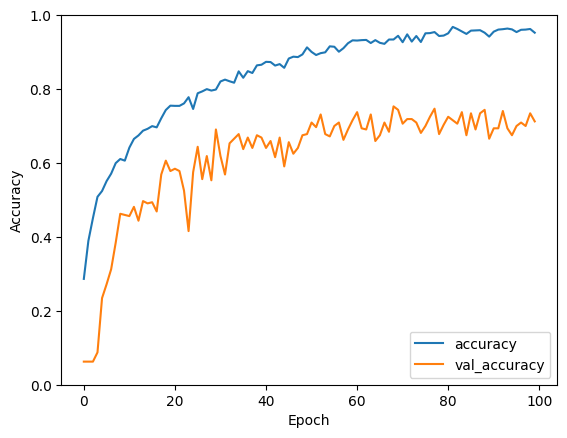

In [47]:
net.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
eval_net(net, epochs=100, load_from_file=False, net_name="lrg_cnn_aug_reg", summary=False,show_train_graph=True, data_aug=True, verbose=True)
# train_info = net.fit(x_train, y_train, batch_size=256,
#                         validation_data=(x_valid, y_valid),
#                         epochs=500, shuffle=True,)

Epoch 1/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9574 - loss: 0.1192 - val_accuracy: 0.7375 - val_loss: 1.1651
Epoch 2/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9804 - loss: 0.0524 - val_accuracy: 0.7500 - val_loss: 1.0953
Epoch 3/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9840 - loss: 0.0540 - val_accuracy: 0.7719 - val_loss: 1.1247
Epoch 4/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9776 - loss: 0.0618 - val_accuracy: 0.7625 - val_loss: 1.1280
Epoch 5/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9887 - loss: 0.0327 - val_accuracy: 0.7563 - val_loss: 1.1425
Epoch 6/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9876 - loss: 0.0346 - val_accuracy: 0.7594 - val_loss: 1.1328
Epoch 7/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9905 - loss: 0.0312 - val_accuracy: 0.7781 - val_loss: 1.1014
Epoch 8/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9886 - loss: 0.0390 - val_accu

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Train accuracy (tf): 1.00
Test accuracy  (tf): 0.75
Train balanced accuracy (tf): 1.00
Test balanced accuracy  (tf): 0.73


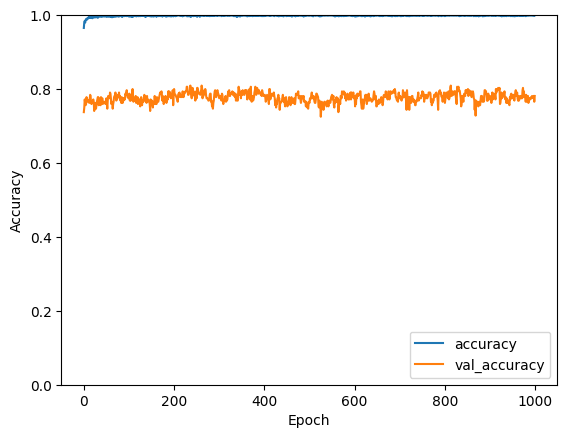

In [48]:
net.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
eval_net(net, epochs=1000, load_from_file=False, net_name="lrg_cnn_aug_reg", summary=False,show_train_graph=True, data_aug=True, verbose=True)
# train_info = net.fit(x_train, y_train, batch_size=256,
#                         validation_data=(x_valid, y_valid),
#                         epochs=500, shuffle=True,)

Epoch 1/8000
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9956 - loss: 0.0010 - val_accuracy: 0.7812 - val_loss: 2.2563
Epoch 2/8000
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9965 - loss: 3.5938e-04 - val_accuracy: 0.7875 - val_loss: 2.2391
Epoch 3/8000
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9980 - loss: 0.0089 - val_accuracy: 0.7844 - val_loss: 2.2227
Epoch 4/8000
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9999 - loss: 0.0013 - val_accuracy: 0.7844 - val_loss: 2.2116
Epoch 5/8000
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9979 - loss: 1.8637e-04 - val_accuracy: 0.7875 - val_loss: 2.1904
Epoch 6/8000
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9993 - loss: 0.0010 - val_accuracy: 0.7875 - val_loss: 2.1879
Epoch 7/8000
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9991 - loss: 4.0598e-04 - val_accuracy: 0.7875 - val_loss: 2.1898
Epoch 8/8000
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9980 - loss: 0.001

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Train accuracy (tf): 1.00
Test accuracy  (tf): 0.78
Train balanced accuracy (tf): 1.00
Test balanced accuracy  (tf): 0.74


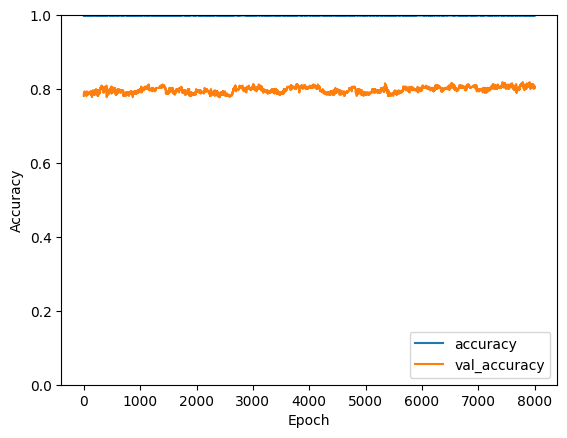

: 

In [49]:
net.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
eval_net(net, epochs=8000, load_from_file=False, net_name="lrg_cnn_aug_reg", summary=False,show_train_graph=True, data_aug=True, verbose=True)
# train_info = net.fit(x_train, y_train, batch_size=256,
#                         validation_data=(x_valid, y_valid),
#                         epochs=500, shuffle=True,)

In [ ]:
net.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
eval_net(net, epochs=2000, load_from_file=False, net_name="lrg_cnn_aug_reg", summary=False,show_train_graph=True, data_aug=True, verbose=True)
# train_info = net.fit(x_train, y_train, batch_size=256,
#                         validation_data=(x_valid, y_valid),
#                         epochs=500, shuffle=True,)